In [93]:
from census import Census
import numpy as np
import pandas as pd

import geopandas as gpd

import cenpy as cen

from us import states

import matplotlib.pyplot as plt
%matplotlib inline

# Load PLUTO Data

In [95]:
filename = 'data/pluto_census_tract.geojson'
pluto = gpd.read_file(filename)

In [96]:
pluto.head()

,address,bbl,cb2010,ct2010,geometry
0,668 CARY AVENUE,5002230055,1004,125,"(POLYGON ((-74.12380400000001 40.63145, -74.12..."
1,666 CARY AVENUE,5002230057,1004,125,"(POLYGON ((-74.123716 40.631469, -74.123804000..."
2,656 CARY AVENUE,5002230060,1004,125,"(POLYGON ((-74.12279599999999 40.631304, -74.1..."
3,TAYLOR STREET,5002230078,1004,125,"(POLYGON ((-74.12278499999999 40.631222, -74.1..."
4,296 TAYLOR STREET,5002230080,1004,125,"(POLYGON ((-74.122761 40.631034, -74.123231 40..."


In [97]:
print(len(set(pluto['ct2010'])))
len((set(pluto['cb2010'])))

1336


369

# Get Tract Income and Population from Census 2010

In [98]:
c = Census("13c056d339e329f0a4fbef4384e3667e505a55da")
c.acs5.tables()

[{'name': 'B07012',
  'description': 'GEOGRAPHICAL MOBILITY IN THE PAST YEAR BY POVERTY STATUS IN THE PAST 12 MONTHS FOR CURRENT RESIDENCE IN THE UNITED STATES',
  'variables': 'https://api.census.gov/data/2017/acs/acs5/groups/B07012.json'},
 {'name': 'B07013',
  'description': 'GEOGRAPHICAL MOBILITY IN THE PAST YEAR BY TENURE FOR CURRENT RESIDENCE IN THE UNITED STATES',
  'variables': 'https://api.census.gov/data/2017/acs/acs5/groups/B07013.json'},
 {'name': 'B13002A',
  'description': 'WOMEN 15 TO 50 YEARS WHO HAD A BIRTH IN THE PAST 12 MONTHS BY MARITAL STATUS (WHITE ALONE)',
  'variables': 'https://api.census.gov/data/2017/acs/acs5/groups/B13002A.json'},
 {'name': 'B13002C',
  'description': 'WOMEN 15 TO 50 YEARS WHO HAD A BIRTH IN THE PAST 12 MONTHS BY MARITAL STATUS (AMERICAN INDIAN AND ALASKA NATIVE ALONE)',
  'variables': 'https://api.census.gov/data/2017/acs/acs5/groups/B13002C.json'},
 {'name': 'B13002B',
  'description': 'WOMEN 15 TO 50 YEARS WHO HAD A BIRTH IN THE PAST 12 M

In [99]:
pop = pd.DataFrame(c.acs5.get('B01003_001E', geo={'for': 'tract:*',
                       'in': 'state:{}'.format(states.NY.fips)}))

In [101]:
income = pd.DataFrame(c.acs5.get('B19013_001E', geo={'for': 'tract:*',
                       'in': 'state:{}'.format(states.NY.fips)}))

# Address to tract income and population

In [102]:
def reformat_pluto_tract_num(tract):
    tract = tract.replace(".", "")
    while len(tract) < 6:
        tract = '0' + tract
    return tract

In [106]:
def generate_report(building_profile):
    building_tract = reformat_pluto_tract_num(pluto[pluto['address'] == building_profile['address']]['ct2010'].values[0])
#     print(f"Build Census Tract: {building_tract}")
    tract_income = float(income[income['tract'] == building_tract]['B19013_001E'])
    print(f"Building Census Tract Income: {tract_income}")
    tract_population = float(pop[pop['tract'] == building_tract]['B01003_001E'])
    print(f"Building Census Tract Population: {tract_population}")
    print("\n")
    
    income_similarity = 5000
    
    # Step 1 Logic
    if (building_profile['expected_income'] < tract_income + income_similarity) and (building_profile['expected_income'] > tract_income - income_similarity):
        print("Step 1: No further analysis needed")
    else:
        print("Step 1: Expecterd average incomes of new population is not similar to average income of the study area populations. Further analysis is required")
        population_increase = (building_profile['num_residence'] + tract_population) / tract_population
#         print(population_increase)
        print("\n")
        # Step 2 Logic
        if population_increase < 1.05:
            print("Step 2: No further analysis required")
        else:
            print("Step 2: Population increase is greater than 5%. Futher analysis is required.")
            
        

In [107]:
# Define Building Profile
building_profile = {"num_residence": 1000, "expected_income": 120000, "address": '1 EAST LOOP ROAD'}

In [108]:
generate_report(building_profile)

Building Census Tract Income: 88724.0
Building Census Tract Population: 9300.0


Step 1: Expecterd average incomes of new population is not similar to average income of the study area populations. Further analysis is required


Step 2: Population increase is greater than 5%. Futher analysis is required.


# Zillow Data

In [85]:
from shapely.geometry import Point, Polygon
from geopy.geocoders import Nominatim

In [87]:
zillow_data = pd.read_csv('data/Neighborhood_Zhvi_AllHomes.csv')
zillow_data = zillow_data[zillow_data['City'] == 'New York']
print(len(set(zillow_data['RegionName'])))

194


In [89]:
# Load Shapefile
zillow_shape_file = gpd.read_file('data/ZillowNeighborhoods-NY/ZillowNeighborhoods-NY.shp')
zillow_shape_file = zillow_shape_file[zillow_shape_file['City'] == 'New York']
zillow_shape_file.head()

,State,County,City,Name,RegionID,geometry
2,NY,Queens,New York,Rego Park,6719,POLYGON ((-73.85629999999999 40.72303000000012...
5,NY,Queens,New York,Belle Harbor,10329,POLYGON ((-73.85618223699993 40.56810940300005...
10,NY,New York,New York,Roosevelt Island,20239,POLYGON ((-73.96143117599991 40.74851331600007...
13,NY,Queens,New York,Howard Beach,21970,POLYGON ((-73.85608525799972 40.65037135900031...
16,NY,Queens,New York,Breezy Point,37557,POLYGON ((-73.90962826099991 40.56552556300005...


In [90]:
# Functions for getting zillow real estate trends of an area
def address_to_neighborhood(addr):
    """Returns a Zillow neighborhood given an address"""
    geolocator = Nominatim(user_agent="collate")
    location = geolocator.geocode(addr)
    location = Point(location.longitude, location.latitude)
    
    for i, row in zillow_shape_file.iterrows():
        polygon = row.get('geometry')
        if location.within(polygon):
            return row.get('Name')
        
def address_realestate_features(addr, years=2):
    """Returns zillow data given an address"""
    neighborhood = address_to_neighborhood(addr)
    features = zillow_data[zillow_data['RegionName'] == neighborhood]
    return features.iloc[:,-12 * years :]
    

def plot_realestate_trends(addr, years=2):
    """Plots zillow realestate trends given an address and year interval"""
    features = address_realestate_features(addr, years)
    x = list(features)
    addr_y = features.values.reshape(len(x))
    
    city_average = zillow_data[zillow_data.columns[-years * 12:]].mean(axis=0)
    
    plt.figure(figsize=(15,10))
    plt.xticks(rotation=90)
    plt.plot(x, addr_y)
    plt.plot(x, city_average)  

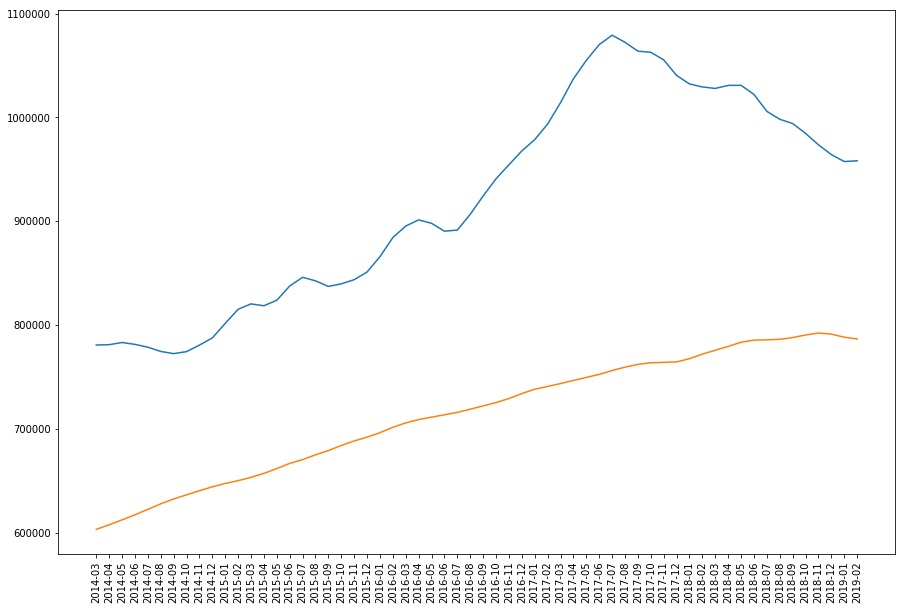

In [91]:
plot_realestate_trends("1 East Loop Rd.", years=5)
# Do we have to control for inflation / natural growth of real estate prices?